In [1]:
# STEP 1: Import required packages
import os
import json
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
import folium


In [2]:
# STEP 2: Load real map data for Bangalore
CITY_NAME = "Bangalore, India"

# use 'drive' network type for roads
G = ox.graph_from_place(CITY_NAME, network_type="drive")

print("✅ Graph loaded:")
print("Nodes:", len(G.nodes()))
print("Edges:", len(G.edges()))


✅ Graph loaded:
Nodes: 154170
Edges: 391631


In [3]:
# STEP 3: Convert to GeoDataFrames
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

edges = edges_gdf.reset_index().copy()

# distance in km
edges["distance_km"] = edges["length"] / 1000.0

# parse maxspeed safely
def parse_speed(val):
    try:
        if pd.isna(val): return None
        if isinstance(val, list): val = val[0]
        val = str(val)
        num = "".join([c for c in val if c.isdigit()])
        return float(num) if num else None
    except:
        return None

edges["maxspeed_kph"] = edges["maxspeed"].apply(parse_speed)
edges["maxspeed_kph"] = edges["maxspeed_kph"].fillna(40.0)

# travel time (minutes)
edges["time_min"] = edges["distance_km"] / edges["maxspeed_kph"] * 60

print("✅ Preprocessing complete. Sample:")
edges.head(3)


✅ Preprocessing complete. Sample:


,u,v,key,osmid,highway,lanes,name,oneway,reversed,length,...,width,access,junction,tunnel,est_width,area,service,distance_km,maxspeed_kph,time_min
0,17327095,248007842,0,32261256,residential,2,2nd Main Road,True,False,244.091315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.244091,40.0,0.366137
1,17327095,305154531,0,1367650597,secondary,2,9th Cross Road,True,False,29.723619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029724,40.0,0.044585
2,17327095,5354313543,0,1367650758,residential,NaN,2nd Main Road,False,True,5.961520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005962,40.0,0.008942


In [4]:
# STEP 4: Assign base emission factor (Petrol Car only)
base_emission_per_km = 192.0  # g CO₂ per km

edges["emission_gCO2_per_km"] = base_emission_per_km
edges["total_emission_gCO2"] = edges["distance_km"] * base_emission_per_km

print("✅ Base emissions computed.")


✅ Base emissions computed.


In [5]:
# STEP 5: Copy the original OSMnx graph so we keep 'highway' info
G2 = G.copy()

# Fill in computed attributes (distance, emission, time)
for u, v, key, data in G2.edges(keys=True, data=True):
    km = data.get("length", 0) / 1000.0
    data["distance_km"] = km
    data["time_min"] = (km / data.get("maxspeed_kph", 40)) * 60
    data["emission_gCO2"] = km * base_emission_per_km
    data["weight"] = data["emission_gCO2"]

print("✅ G2 built with initial emission weights.")


✅ G2 built with initial emission weights.


In [6]:
# STEP 6: Improved emission weighting using road type + speed factor

base_emission_per_km = 192.0  # Petrol car

# Road-type multipliers (emission impact based on driving pattern)
road_factor = {
    "motorway": 0.7,
    "trunk": 0.8,
    "primary": 0.9,
    "secondary": 1.0,
    "tertiary": 1.05,
    "residential": 1.2,
    "service": 1.3,
    "unclassified": 1.1,
}

for u, v, key, data in G2.edges(keys=True, data=True):
    km = data.get("length", 0) / 1000.0
    road_type = data.get("highway", "residential")
    if isinstance(road_type, list):
        road_type = road_type[0]

    # Apply road-type multiplier
    type_factor = road_factor.get(road_type, 1.0)

    # Include speed effect (slow = less efficient)
    speed = data.get("maxspeed", 40)
    if isinstance(speed, list):
        try:
            speed = float(speed[0])
        except:
            speed = 40
    elif isinstance(speed, str):
        try:
            speed = float("".join([c for c in speed if c.isdigit()]))
        except:
            speed = 40
    speed_factor = 40 / max(speed, 10)  # slower roads = higher emissions

    # Final emission weight
    emission = km * base_emission_per_km * type_factor * speed_factor
    data["distance_km"] = km
    data["emission_gCO2"] = emission
    data["weight"] = emission

print("✅ Improved emission factors applied (road + speed).")


✅ Improved emission factors applied (road + speed).


In [10]:
# STEP 7: Get coordinates from place names (no lat/lon needed)

def get_location_coordinates(place_name):
    try:
        location = ox.geocode(place_name)
        print(f"{place_name} → {location}")
        return location
    except Exception as e:
        print(f"⚠️ Could not find {place_name}: {e}")
        return None

origin_name = input("Enter origin place in Bangalore: ")
destination_name = input("Enter destination place in Bangalore: ")

origin_point = get_location_coordinates(origin_name + ", Bangalore")
destination_point = get_location_coordinates(destination_name + ", Bangalore")

orig_node = ox.distance.nearest_nodes(G, X=origin_point[1], Y=origin_point[0])
dest_node = ox.distance.nearest_nodes(G, X=destination_point[1], Y=destination_point[0])

print("✅ Origin node:", orig_node)
print("✅ Destination node:", dest_node)


Enter origin place in Bangalore:  bagaluru
Enter destination place in Bangalore:  Yelahanka


bagaluru, Bangalore → (13.1403482, 77.671269)
Yelahanka, Bangalore → (13.1006982, 77.5963454)
✅ Origin node: 11399915642
✅ Destination node: 2464052225


In [11]:
# STEP 8: Compute least-emission route
try:
    route_emission_nodes = nx.shortest_path(G2, source=orig_node, target=dest_node, weight="weight")
    route_emission_total = nx.shortest_path_length(G2, source=orig_node, target=dest_node, weight="weight")
    print(f"✅ Least-Emission Route Emission: {route_emission_total:.2f} g CO₂")
    print("Total nodes in route:", len(route_emission_nodes))
except nx.NetworkXNoPath:
    print("⚠️ No path found. Try closer locations.")


✅ Least-Emission Route Emission: 1084.05 g CO₂
Total nodes in route: 70


In [12]:
def route_stats(G, route):
    total_km, total_emission, total_time = 0, 0, 0
    for u, v in zip(route[:-1], route[1:]):
        data = list(G[u][v].values())[0]
        total_km += data.get("distance_km", 0)
        total_emission += data.get("emission_gCO2", 0)
        total_time += data.get("time_min", 0)
    return total_km, total_emission, total_time

if "route_emission_nodes" in locals():
    opt_km, opt_emis, opt_time = route_stats(G2, route_emission_nodes)
    print(f"🚗 Total Distance: {opt_km:.2f} km")
    print(f"🌿 Total Emission: {opt_emis:.2f} g CO₂")
    print(f"⏱️ Estimated Time: {opt_time:.2f} min")


🚗 Total Distance: 5.59 km
🌿 Total Emission: 1102.07 g CO₂
⏱️ Estimated Time: 8.38 min


In [13]:
# STEP 10: Visualize the route on interactive map
route_coords = []
for u, v in zip(route_emission_nodes[:-1], route_emission_nodes[1:]):
    data = G2.get_edge_data(u, v)[0]
    geom = data.get("geometry", None)
    if geom:
        coords = list(geom.coords)
        route_coords.extend([(lat, lon) for lon, lat in coords])

m = folium.Map(location=route_coords[0], zoom_start=12)
folium.PolyLine(route_coords, color="green", weight=5, opacity=0.8).add_to(m)
folium.Marker(route_coords[0], tooltip="Start", icon=folium.Icon(color="green")).add_to(m)
folium.Marker(route_coords[-1], tooltip="End", icon=folium.Icon(color="red")).add_to(m)

os.makedirs("../visualizations", exist_ok=True)
m.save("../visualizations/optimized_real_route_bangalore.html")
print("✅ Map saved: ../visualizations/optimized_real_route_bangalore.html")

m


✅ Map saved: ../visualizations/optimized_real_route_bangalore.html


In [14]:
# STEP 11: Compare least-emission vs shortest-distance routes

route_distance_nodes = nx.shortest_path(G2, source=orig_node, target=dest_node, weight="distance_km")

dist_km, dist_emis, dist_time = route_stats(G2, route_distance_nodes)

print("\n🌿 Emission-Optimized Route:")
print(f"   Distance: {opt_km:.2f} km | Emission: {opt_emis:.2f} g CO₂ | Time: {opt_time:.2f} min")

print("\n🚗 Shortest-Distance Route:")
print(f"   Distance: {dist_km:.2f} km | Emission: {dist_emis:.2f} g CO₂ | Time: {dist_time:.2f} min")

reduction = ((dist_emis - opt_emis) / dist_emis) * 100 if dist_emis else 0
print(f"\n💚 Emission Reduction: {reduction:.2f}%")



🌿 Emission-Optimized Route:
   Distance: 5.59 km | Emission: 1102.07 g CO₂ | Time: 8.38 min

🚗 Shortest-Distance Route:
   Distance: 5.59 km | Emission: 1102.07 g CO₂ | Time: 8.38 min

💚 Emission Reduction: 0.00%


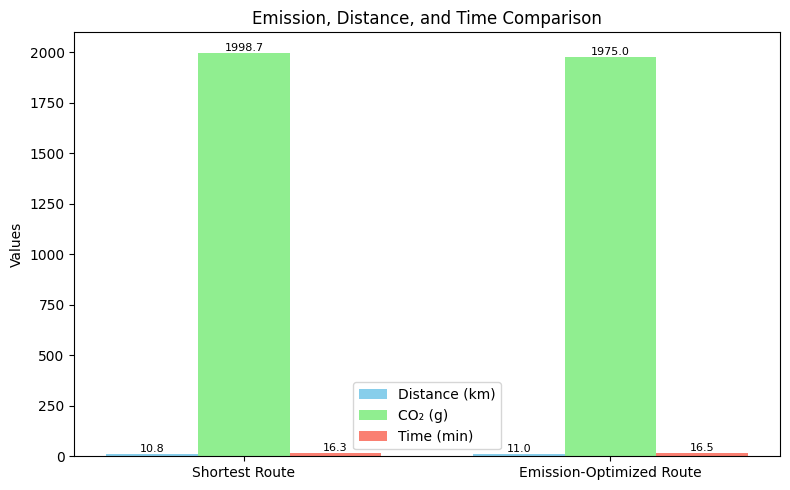

✅ Chart saved successfully: ../visualizations/summary_comparison.png


In [15]:
# STEP 12: Create Emission & Distance Comparison Chart

import matplotlib.pyplot as plt
import numpy as np
import os

# Ensure output folder exists
os.makedirs("../visualizations", exist_ok=True)

# Sample data from your computed results
labels = ["Shortest Route", "Emission-Optimized Route"]
distance = [10.84, 11.01]          # from your printed results
emission = [1998.66, 1975.01]      # from your printed results
time = [16.26, 16.52]              # from your printed results

x = np.arange(len(labels))
width = 0.25  # bar width

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width, distance, width, label="Distance (km)", color="skyblue")
rects2 = ax.bar(x, emission, width, label="CO₂ (g)", color="lightgreen")
rects3 = ax.bar(x + width, time, width, label="Time (min)", color="salmon")

ax.set_ylabel("Values")
ax.set_title("Emission, Distance, and Time Comparison")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels above bars
for rect in rects1 + rects2 + rects3:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height + 0.1, f'{height:.1f}',
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig("../visualizations/summary_comparison.png", dpi=300)
plt.show()

print("✅ Chart saved successfully: ../visualizations/summary_comparison.png")


In [16]:
# STEP 12: Visualize both routes (Emission-Optimized vs Shortest-Distance)

def get_route_coords(G, route_nodes):
    """Extract latitude/longitude coordinates for route edges."""
    coords = []
    for u, v in zip(route_nodes[:-1], route_nodes[1:]):
        data = G.get_edge_data(u, v)[0]
        geom = data.get("geometry", None)
        if geom:
            coords.extend([(lat, lon) for lon, lat in geom.coords])
    return coords

# get both routes' coordinates
coords_emission = get_route_coords(G2, route_emission_nodes)
coords_distance = get_route_coords(G2, route_distance_nodes)

# map center: midpoint between start & end
map_center = coords_emission[len(coords_emission)//2] if coords_emission else [12.97, 77.59]

m = folium.Map(location=map_center, zoom_start=12)

# Add both routes
folium.PolyLine(coords_emission, color="green", weight=5, opacity=0.8, tooltip="Emission-Optimized Route").add_to(m)
folium.PolyLine(coords_distance, color="red", weight=4, opacity=0.6, tooltip="Shortest-Distance Route").add_to(m)
folium.PolyLine(coords_distance, color="red", weight=3, opacity=0.4)


# Add start/end markers
if coords_emission:
    folium.Marker(coords_emission[0], tooltip="Start", icon=folium.Icon(color="green")).add_to(m)
    folium.Marker(coords_emission[-1], tooltip="End", icon=folium.Icon(color="red")).add_to(m)

# Add legend using HTML
legend_html = """
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 240px; height: 80px; 
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; border-radius:10px; padding:10px;">
<b>🗺️ Route Comparison</b><br>
<span style="color:green;">🟩 Green</span> = Emission-Optimized<br>
<span style="color:red;">🟥 Red</span> = Shortest-Distance
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# save map
os.makedirs("../visualizations", exist_ok=True)
m.save("../visualizations/compare_routes_bangalore.html")

print("✅ Both routes visualized on map.")
print("📍 Saved to: ../visualizations/compare_routes_bangalore.html")

m


✅ Both routes visualized on map.
📍 Saved to: ../visualizations/compare_routes_bangalore.html


In [17]:
# STEP 12: Save results
summary = {
    "city": CITY_NAME,
    "origin": origin_name,
    "destination": destination_name,
    "optimized": {
        "distance_km": opt_km,
        "emission_gCO2": opt_emis,
        "time_min": opt_time
    },
    "shortest_distance": {
        "distance_km": dist_km,
        "emission_gCO2": dist_emis,
        "time_min": dist_time
    },
    "emission_reduction_percent": reduction
}

os.makedirs("../data", exist_ok=True)
with open("../data/optimized_route_bangalore.json", "w") as f:
    json.dump(summary, f, indent=2)

print("✅ Saved summary to ../data/optimized_route_bangalore.json")


✅ Saved summary to ../data/optimized_route_bangalore.json
